In [150]:
import numpy as np
import pandas as pd
import random
import seaborn as sns

In [151]:
from itertools import combinations, product
from functools import reduce
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import chi2_contingency, shapiro, probplot, mannwhitneyu
from matplotlib import pyplot as plt
from tqdm import tqdm, trange
%matplotlib inline

In [152]:
import xgboost as xgb
import catboost as catb
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [153]:
SAMPLE = 7500

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

def balance_df_by_target(df, target_name, pr):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.idxmax()
    minor_class_name = target_counts.idxmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1 

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(int(target_counts[minor_class_name] * pr))
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

def show_size_matching(df, col):
    plt.figure(figsize=(10, 8))

    sns.countplot(x=col, hue=TARGET_NAME, data=df)
    plt.title(f'{col} grouped by target variable')
    plt.legend(title='Target', loc='upper right')

    plt.show()

def show_chi2_p_vals(df, col):
    vals = list(df.loc[~df[col].isna(), col].unique())
    res = pd.DataFrame(index=sorted(vals), columns=sorted(vals))
    for v1, v2 in product(vals, vals):
        main_value_and_target_s = df.loc[df[col].isin([v1, v2]), ['Id', col, TARGET_NAME]]
        main_value_table = main_value_and_target_s.pivot_table(values='Id', index=col, columns=TARGET_NAME, aggfunc='count')
        _, p, _, _ = chi2_contingency(main_value_table, correction=False)
        res.loc[v1, v2] = round(p, 4)
    print(res)

def get_target_ranges(df, col):
    col_with_target_s = df[[col, TARGET_NAME]]
    col_s = col_with_target_s[col]
    col_target_0 = col_s[col_with_target_s[TARGET_NAME] == 0]
    col_target_1 = col_s[col_with_target_s[TARGET_NAME] == 1]
    return col_s, col_target_0, col_target_1
    
def show_plot_matching(df, col):
    col_s, col_target_0, col_target_1 = get_target_ranges(df, col)
    plt.figure(figsize=(10, 5))

    sns.kdeplot(col_target_0, shade=True, label='No default', color='g')
    sns.kdeplot(col_target_1, shade=True, label='Default', color='r')

    plt.xlabel(col)
    plt.title(f'{col} grouped by target variable')
    plt.show()

def show_shapiro(df, col):
    col_s, _, _ = get_target_ranges(df, col)
    return shapiro(col_s)

def show_normal_matching(df, col):
    col_s, _, _ = get_target_ranges(df, col)
    plt.figure(figsize=(20, 8))

    ax1 = plt.subplot(121)
    ax1.set_xlabel(col)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{col} distribution')
    col_s.hist()

    plt.subplot(122)
    probplot(col_s, dist='norm', plot=plt)
    plt.show()

def show_confidence_int(df, col):
    plt.figure(figsize=(8, 5))

    sns.pointplot(x=TARGET_NAME, y=col, data=df[[col, TARGET_NAME]], capsize=.1)

    plt.title(f'Confidence intervals (95 %) for {col}')
    plt.show()

def show_mannwhitneyu(df, col):
    _, col_target_0, col_target_1 = get_target_ranges(df, col)
    return mannwhitneyu(col_target_0, col_target_1)

In [154]:
def mod_Home_Ownership(df, col='Home Ownership'):
    df.loc[df[col].isin(['Rent', 'Own Home']), col] = 1
    df.loc[df[col].isin(['Have Mortgage', 'Home Mortgage']), col] = 0
    
    return df

def mod_Tax_Liens(df, col='Tax Liens'):
    df.loc[df[col].isin([0, 1]), col] = 0
    df.loc[df[col] >= 2, col] = 1
    df[col] = df[col].astype('int8')
    return df

def mod_Term(df, col='Term'):
    df[col] = df[col].map({'Short Term': '0', 'Long Term': '1'}).astype('int8')
    return df

def mod_Purpose(df, col='Purpose'):
    df.loc[df[col].isin(['take a trip', 'debt consolidation', 'wedding', 
                         'buy house', 'vacation', 'renewable energy']), col] = 'debt consolidation'
    df.loc[df[col].isin(['major purchase', 'buy a car', 'home improvements', 'moving', 'educational expenses']), col] = 'buy a car '
    df.loc[df[col].isin(['medical bills', 'other']), col] = 'other'
    df.loc[df[col].isin(['business loan', 'small business']), col] = 'bisness'
    
    uniq = list(df[col].unique())
    for name, i in zip(uniq, range(0, len(uniq))):
        df.loc[df[col] == name, col] = f'{i}'
    df[col] = df[col].astype('str')
    
    return df

def mod_Current_Loan_Amount(df, median, p, col='Current Loan Amount'):
    df.loc[df[col] == 99999999.0, col] = 0
    df = mod_remove_tail(df, col, p)
    return df

def mod_Number_of_Credit_Problems(df, col='Number of Credit Problems'):
    df.loc[df[col].isin([0, 1]), col] = 0
    df.loc[df[col] >= 4, col] = 4
    df.loc[df[col].isin([2, 3]), col] = 3
    df[col] = df[col].astype('int')
    return df

def mod_Credit_Score(df, median, col='Credit Score'):
    df.loc[df[col] > 800, col] = df[col] / 10
    df[col] = df[col].fillna(median)
    return df

def mod_Annual_Income(df, median, p, col='Annual Income'):
#     df[col] = df[col].fillna(median)
    df_clear = df.loc[~(df[col].isna()) & (df['Monthly Debt'] > 100), [col, 'Monthly Debt']]
    mean_dept_coeff = (df_clear[col] / 12 / df_clear['Monthly Debt']).mean()
    df.loc[df[col].isna(), col] = df['Monthly Debt'] * 12 * mean_dept_coeff
    df = mod_remove_tail(df, col, p)
    return df


def mod_Years_in_current_job(df, mode, col='Years in current job'):
    df[col] = df[col].fillna(mode)
    df.loc[df[col] == '10+ years', [col]] = '10'
    df.loc[df[col] == '< 1 year', [col]] = '0'
    df[col] = df[col].apply(lambda x: str(x).split()[0])
    df[col] = df[col].astype('int')
    return df

def mod_Bankruptcies(df, col='Bankruptcies'):
    df[col] = df[col].fillna(0)
    df.loc[df[col] > 2, col] = 2
    df[col] = df[col].astype('int8')
    return df

def mod_Months_since_last_delinquent(df,  med_d, max_d, col='Months since last delinquent'):
    extend = 12
    df.loc[((df[curr_name].isna()) & df['Number of Credit Problems'] > 0) | (df['Bankruptcies'] > 0), col] = med_d
    df[col] = df[col].fillna(max_d + extend)
    df.loc[df[col] > max_d, col] = max_d + extend
    return df

def mod_remove_tail(df, col, quantile_p, left=False):
    if left:
        df.loc[df[col] < quantile_p, col] = quantile_p
        return df
    df.loc[df[col] > quantile_p, col] = quantile_p
    return df

def mod_scaler(df):
    scaler = StandardScaler()
    df_norm = df.copy()
    df_norm[numerical_columns] = scaler.fit_transform(df_norm[numerical_columns])
    return df_norm.copy()

In [155]:
def add_Number_of_Credit_Problems(df, col='Number of Credit Problems'):
    coef = df.loc[(df[col]==4) & (df[TARGET_NAME] != 0), col].count()/df.loc[(df[col]==4) & (df[TARGET_NAME] == 0), col].count()
    for i in [6, 7]:
        count_rows = df.loc[df[col] == i, col].count()
        temp_df = df.loc[(df[col].isin([2, 3, 4, 5]) & (df[TARGET_NAME]==1))].sample(count_rows * int(coef))
        temp_df[col] = i
        df = df.append(temp_df, ignore_index=True)
    return df

def add_Tax_Liens(df, col='Tax Liens'):
    for i in [6, 7]:
        count_rows = df.loc[df[col] == i, col].count()
        temp_df = df.loc[(df[col].isin([3, 4, 5]) & (df[TARGET_NAME]==1))].sample(count_rows)
        temp_df[col] = i
        df = df.append(temp_df, ignore_index=True)
    return df

In [156]:
def new_Months_since_last_delinquent_dummy(df, col='Months since last delinquent'):
    new_col = col + '_dummy'
    def discrete(value):
        return  {  value == 0: '0',
              1 <= value <  3: '1',
              3 <= value <  6: '2',
              6 <= value < 12: '3',
             12 <= value < 36: '4',
             36 <= value     : '5',}[True]
    df[new_col] = df[col].map(discrete) 
    return df

def new_Credit_Score_bin(df, col='Credit Score'):
    bad_gays = df[col].quantile(0.2)
    df[col + '_bin'] = df[col].map(lambda x: 1 if x < bad_gays else 0)
    return df

def new_Bankruptcies_bin(df, col='Bankruptcies'):
    df[col + '_bin'] = df[col].map(lambda x: 1 if x != 0 else 0)
    return df

def new_Bankruptcies_bin2(df,  col='Bankruptcies'):
    df[col + '_bin2'] = df[col].map(lambda x: 0 if x < 2  else 1)
    return df

***Пути, Данные и связанные с ними переменные***

In [157]:
DATASET_FILE = 'datasets/train.csv'
DATASET_TEST_FILE = 'datasets/test.csv'
PRED_OUTPUT_FILE = 'KMSidorov_predictions.csv'

In [158]:
drop_columns = ['Id']

***Загрузка и первичный осмотр данных***

In [159]:
df_test = pd.read_csv(DATASET_TEST_FILE)
df = pd.read_csv(DATASET_FILE)
# df = df.set_index('Id')
df.head()

,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
Id                              7500 non-null int64
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    594

***Выделим целевуб ппеременную***

In [161]:
TARGET_NAME = 'Credit Default'
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [162]:
# for col in nonbinary_columns:
#     print(f'Name:{col}. type: {df[col].dtype}')
#     print(f'Количество уникальных элементов {len(df[col].unique())}, всего элементов {len(df[col])}')
#     print(df[col].value_counts())
#     print('-'*100)

<h2 ><span style="color:red">Years in current job</span> BEGIN

In [163]:
curr_name = 'Years in current job'

In [164]:
df.loc[(df[curr_name].isna()) & (df[TARGET_NAME] == 1), ['Id', curr_name]].count()[0]

137

In [165]:
mode = df[curr_name].mode()[0]
df = mod_Years_in_current_job(df, mode)
df_test = mod_Years_in_current_job(df_test, mode)

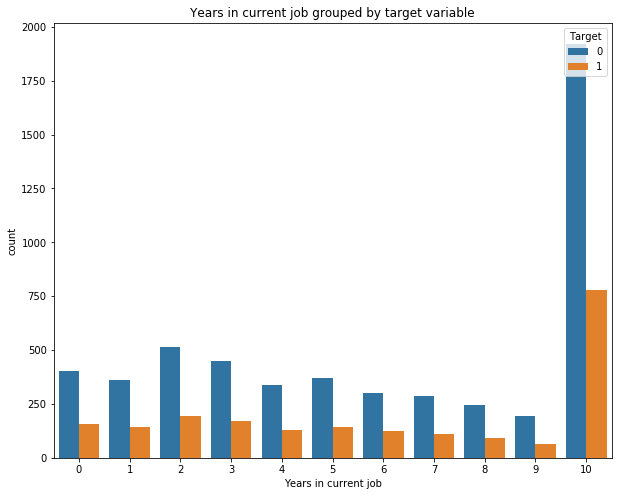

In [166]:
show_size_matching(df, curr_name)

In [167]:
show_chi2_p_vals(df, curr_name)

        0       1       2       3       4       5       6       7       8   \
0        1  0.9806  0.7323  0.7526  0.9122   0.959  0.7653  0.9429  0.7203   
1   0.9806       1  0.7596  0.7786  0.9329  0.9791  0.7537  0.9619  0.7419   
2   0.7323  0.7596       1  0.9859  0.8347  0.7797  0.5297  0.8157  0.9358   
3   0.7526  0.7786  0.9859       1  0.8515  0.7984  0.5506  0.8319  0.9257   
4   0.9122  0.9329  0.8347  0.8515       1   0.953   0.697  0.9743  0.8034   
5    0.959  0.9791  0.7797  0.7984   0.953       1  0.7334  0.9813  0.7585   
6   0.7653  0.7537  0.5297  0.5506   0.697  0.7334       1  0.7326  0.5478   
7   0.9429  0.9619  0.8157  0.8319  0.9743  0.9813  0.7326       1  0.7875   
8   0.7203  0.7419  0.9358  0.9257  0.8034  0.7585  0.5478  0.7875       1   
9   0.3468  0.3652  0.4786  0.4781   0.409  0.3747  0.2547  0.4076  0.5739   
10  0.7558  0.7434  0.4269  0.4638  0.6709  0.7154  0.9278   0.723  0.5007   

        9       10  
0   0.3468  0.7558  
1   0.3652  0.7434  


In [168]:
show_mannwhitneyu(df, curr_name)

MannwhitneyuResult(statistic=5633858.0, pvalue=0.2421340749270156)

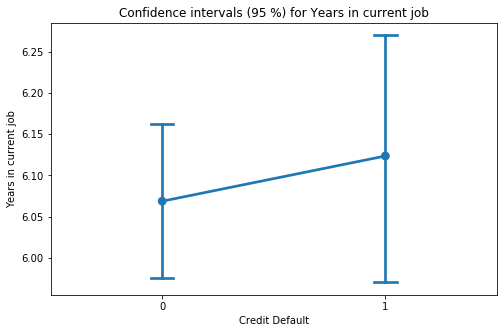

In [169]:
show_confidence_int(df, curr_name)

In [170]:
drop_columns.append(curr_name)

<h2><span style="color:red">Years in current job</span> END<br>
    ________________________________

<h2 ><span style="color:red">Bankruptcies</span> BEGIN

In [171]:
curr_name = 'Bankruptcies'

In [172]:
df[[curr_name, TARGET_NAME]].groupby([curr_name,TARGET_NAME]).size()

Bankruptcies  Credit Default
0.0           0                 4782
              1                 1878
1.0           0                  569
              1                  217
2.0           0                   20
              1                   11
3.0           0                    5
              1                    2
4.0           0                    1
              1                    1
dtype: int64

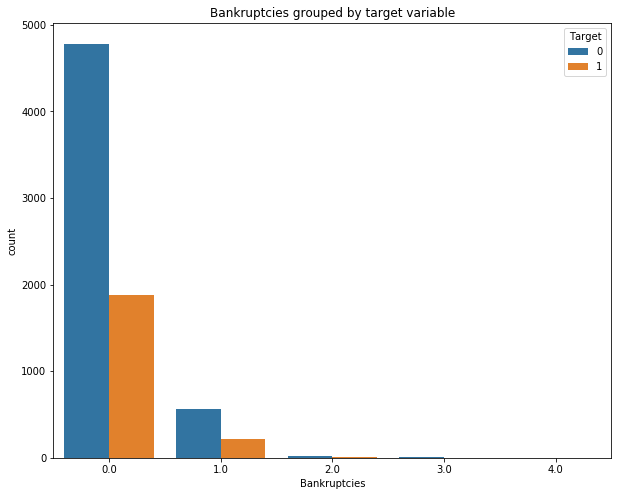

In [173]:
show_size_matching(df, curr_name)

In [174]:
df = mod_Bankruptcies(df)
df_test = mod_Bankruptcies(df_test)

In [175]:
show_chi2_p_vals(df, curr_name)

        0       1       2
0       1  0.7275  0.3408
1  0.7275       1  0.3096
2  0.3408  0.3096       1


In [176]:
drop_columns.append(curr_name)

<h2><span style="color:red">Bankruptcies</span> END<br>
________________________________

<h2 ><span style="color:red">Home Ownership </span> BEGIN

In [177]:
curr_name = 'Home Ownership'

In [178]:
df[curr_name].describe()

count              7500
unique                4
top       Home Mortgage
freq               3637
Name: Home Ownership, dtype: object

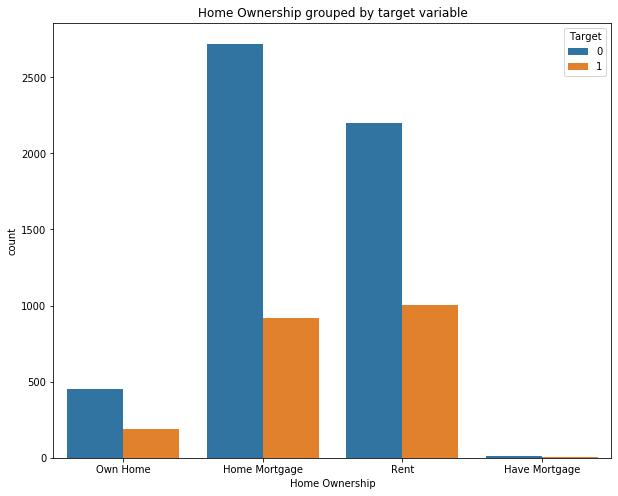

In [179]:
show_size_matching(df, curr_name)

In [180]:
show_chi2_p_vals(df, curr_name)

              Have Mortgage Home Mortgage Own Home    Rent
Have Mortgage             1        0.4972   0.3272  0.2749
Home Mortgage        0.4972             1   0.0163       0
Own Home             0.3272        0.0163        1  0.4139
Rent                 0.2749             0   0.4139       1


In [181]:
df = mod_Home_Ownership(df)
df_test = mod_Home_Ownership(df_test)

In [182]:
show_chi2_p_vals(df, curr_name)

   0  1
0  1  0
1  0  1


<h2><span style="color:red">Home Ownership</span> END<br>________________________________

<h2 ><span style="color:red">Tax Liens</span> BEGIN

In [183]:
curr_name = 'Tax Liens'

In [184]:
# df = add_Tax_Liens(df)

In [185]:
df[curr_name].unique()

array([0., 3., 1., 2., 4., 6., 5., 7.])

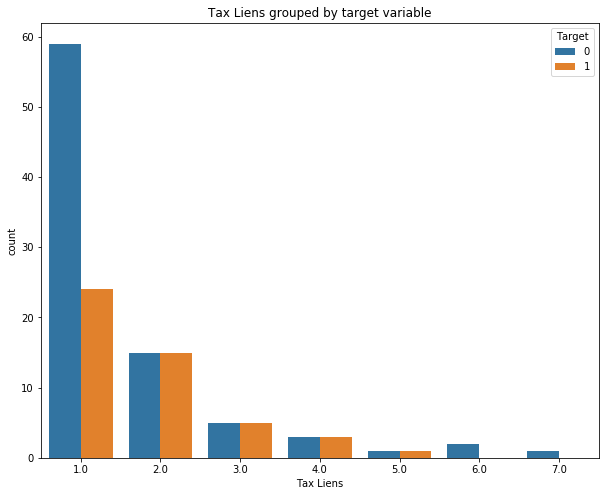

In [186]:
show_size_matching(df.loc[df[curr_name] != 0] , curr_name)

In [187]:
show_chi2_p_vals(df, curr_name)

/home/kach/projects/gb-ds/ds_env/lib/python3.7/site-packages/scipy/stats/contingency.py:244: RuntimeWarning: invalid value encountered in less
  if np.any(observed < 0):


        0.0     1.0     2.0     3.0     4.0     5.0  6.0  7.0
0.0       1  0.8589  0.0076  0.1224  0.2312  0.4893  NaN  NaN
1.0  0.8589       1  0.0374  0.1739   0.278  0.5179  NaN  NaN
2.0  0.0076  0.0374       1       1       1       1  NaN  NaN
3.0  0.1224  0.1739       1       1       1       1  NaN  NaN
4.0  0.2312   0.278       1       1       1       1  NaN  NaN
5.0  0.4893  0.5179       1       1       1       1  NaN  NaN
6.0     NaN     NaN     NaN     NaN     NaN     NaN    1    1
7.0     NaN     NaN     NaN     NaN     NaN     NaN    1    1


In [188]:
df = mod_Tax_Liens(df)
df_test = mod_Tax_Liens(df_test)

In [189]:
show_chi2_p_vals(df, curr_name)

        0       1
0       1  0.0026
1  0.0026       1


<h2><span style="color:red">Tax Liens </span> END<br>________________________________

<h2 ><span style="color:red">Term</span> BEGIN

In [190]:
curr_name = 'Term'

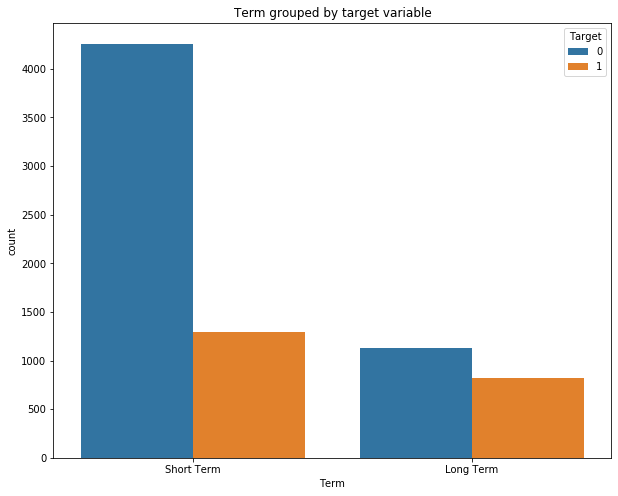

In [191]:
show_size_matching(df, curr_name)

In [192]:
df = mod_Term(df)
df_test = mod_Term(df_test)

<h2><span style="color:red">Term</span> END<br>________________________________

<h2 ><span style="color:red">Purpose</span> BEGIN

In [193]:
curr_name = 'Purpose'

In [194]:
df[curr_name].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

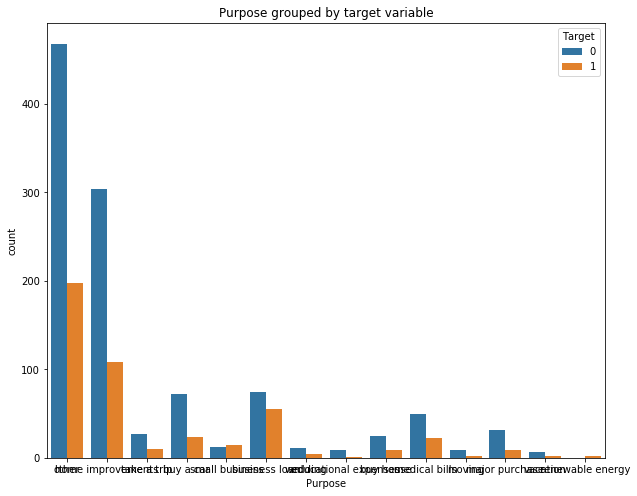

In [195]:
show_size_matching(df.loc[~df[curr_name].isin(['debt consolidation'])], curr_name)

In [196]:
show_chi2_p_vals(df, curr_name)

                     business loan buy a car buy house debt consolidation  \
business loan                    1    0.0061     0.086             0.0002   
buy a car                   0.0061         1    0.8655             0.5397   
buy house                    0.086    0.8655         1             0.8604   
debt consolidation          0.0002    0.5397    0.8604                  1   
educational expenses        0.0427    0.2876    0.2746             0.2087   
home improvements           0.0004    0.8071    0.9739             0.4794   
major purchase              0.0218    0.7566    0.6916             0.4536   
medical bills               0.1052     0.392    0.6351              0.555   
moving                      0.1131    0.6175    0.5782             0.4757   
other                       0.0037    0.3508     0.694             0.3275   
renewable energy               NaN       NaN       NaN                NaN   
small business               0.294    0.0048    0.0307             0.0032   

In [197]:
df = mod_Purpose(df)
df_test = mod_Purpose(df_test)

In [198]:
show_chi2_p_vals(df, curr_name)

        0       1       2       3
0       1  0.2725   0.198       0
1  0.2725       1  0.0754  0.0004
2   0.198  0.0754       1       0
3       0  0.0004       0       1


<h2><span style="color:red">Purpose</span> END<br>________________________________

<h2 ><span style="color:red">Months since last delinquent</span> BEGIN

In [199]:
curr_name = 'Months since last delinquent'

In [200]:
df = mod_Months_since_last_delinquent(df, df[curr_name].median(), df[curr_name].max())
df_test = mod_Months_since_last_delinquent(df_test, df[curr_name].median(), df[curr_name].max())

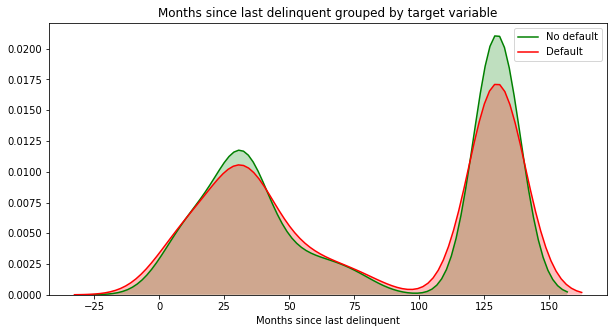

In [201]:
show_plot_matching(df, curr_name)

In [202]:
show_mannwhitneyu(df, curr_name)

MannwhitneyuResult(statistic=5644722.0, pvalue=0.2790417928304931)

In [203]:
drop_columns.append(curr_name)

<h2><span style="color:red">Months since last delinquent</span> END<br>________________________________

<h2 ><span style="color:red">Number of Credit Problems</span> BEGIN

In [204]:
curr_name = 'Number of Credit Problems'

In [205]:
# df = add_Number_of_Credit_Problems(df)

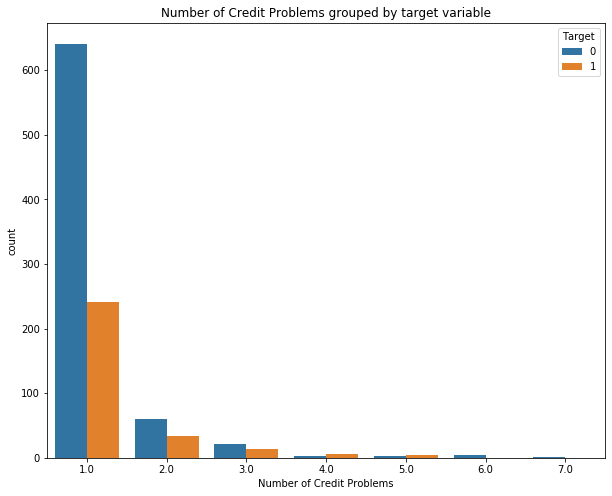

In [206]:
show_size_matching(df.loc[df[curr_name] != 0], curr_name)

In [207]:
show_chi2_p_vals(df, curr_name)

        0.0     1.0     2.0     3.0     4.0     5.0  6.0  7.0
0.0       1  0.6493  0.1139   0.117    0.01   0.087  NaN  NaN
1.0  0.6493       1  0.0959  0.1007  0.0087  0.0786  NaN  NaN
2.0  0.1139  0.0959       1  0.6366   0.066  0.2524  NaN  NaN
3.0   0.117  0.1007  0.6366       1  0.1519  0.4028  NaN  NaN
4.0    0.01  0.0087   0.066  0.1519       1  0.6963  NaN  NaN
5.0   0.087  0.0786  0.2524  0.4028  0.6963       1  NaN  NaN
6.0     NaN     NaN     NaN     NaN     NaN     NaN    1    1
7.0     NaN     NaN     NaN     NaN     NaN     NaN    1    1


In [208]:
df = mod_Number_of_Credit_Problems(df)
df_test = mod_Number_of_Credit_Problems(df_test)

In [209]:
show_chi2_p_vals(df, curr_name)

        0       3       4
0       1   0.029  0.0453
3   0.029       1  0.3408
4  0.0453  0.3408       1


<h2><span style="color:red">Number of Credit Problems</span> END<br>________________________________

<h2 ><span style="color:red">Years of Credit History</span> BEGIN

In [210]:
curr_name = 'Years of Credit History'

In [211]:
quantile_p = int(df[curr_name].quantile(0.70))
df = mod_remove_tail(df, curr_name, quantile_p )
df_test = mod_remove_tail(df_test, curr_name, quantile_p)

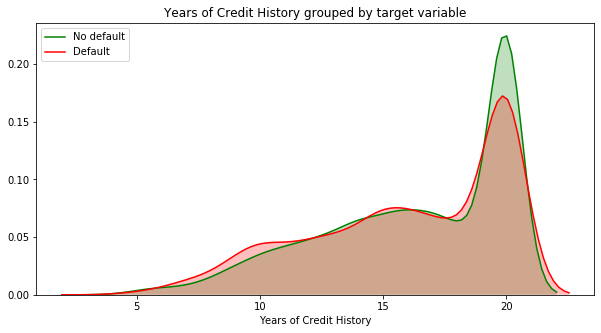

In [212]:
show_plot_matching(df, curr_name)

In [213]:
show_shapiro(df, curr_name)

/home/kach/projects/gb-ds/ds_env/lib/python3.7/site-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.873212993144989, 0.0)

In [214]:
show_mannwhitneyu(df, curr_name)

MannwhitneyuResult(statistic=5418894.5, pvalue=0.000496846647787775)

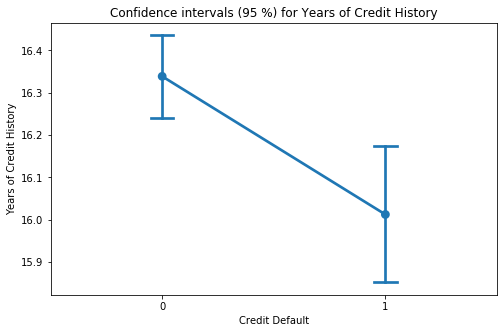

In [215]:
show_confidence_int(df, curr_name)

<h2><span style="color:red">Years of Credit History</span> END<br>________________________________

<h2 ><span style="color:red">Current Loan Amount</span> BEGIN

In [216]:
curr_name = 'Current Loan Amount'

In [217]:
quantile_p = int(df[curr_name].quantile(0.90))
median = df.loc[df[curr_name] < 900000, curr_name].median() 
df = mod_Current_Loan_Amount(df, median, quantile_p)
df_test = mod_Current_Loan_Amount(df_test, median, quantile_p)

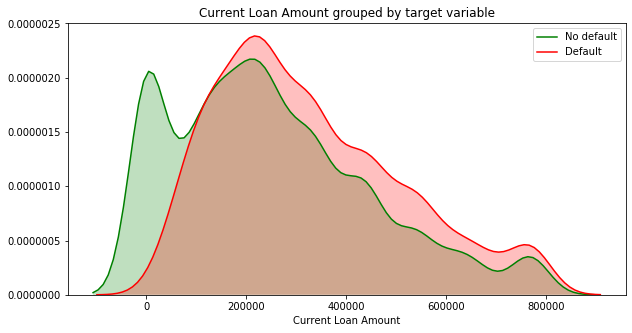

In [218]:
show_plot_matching(df, curr_name)

In [219]:
show_shapiro(df, curr_name)

(0.9484855532646179, 2.802596928649634e-45)

In [220]:
show_mannwhitneyu(df, curr_name)

MannwhitneyuResult(statistic=4375163.0, pvalue=2.8328712625384193e-55)

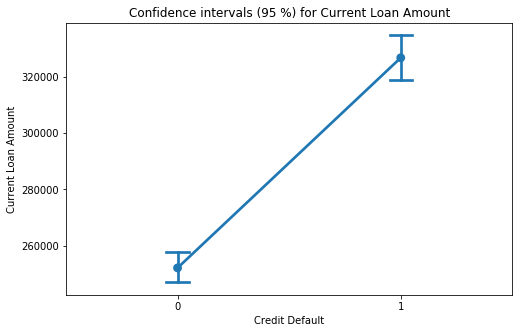

In [221]:
show_confidence_int(df, curr_name)

<h2><span style="color:red">Current Loan Amount</span> END<br>________________________________

<h2 ><span style="color:red">Monthly Debt</span> BEGIN

In [222]:
curr_name = 'Monthly Debt'

In [223]:
quantile_p = int(df[curr_name].quantile(0.85))
df = mod_remove_tail(df, curr_name, quantile_p)
df_test = mod_remove_tail(df_test, curr_name, quantile_p)

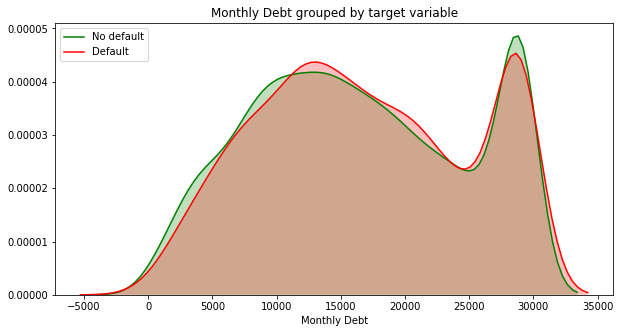

In [224]:
show_plot_matching(df, curr_name)

In [225]:
show_mannwhitneyu(df, curr_name)

MannwhitneyuResult(statistic=5534447.5, pvalue=0.031200239461042216)

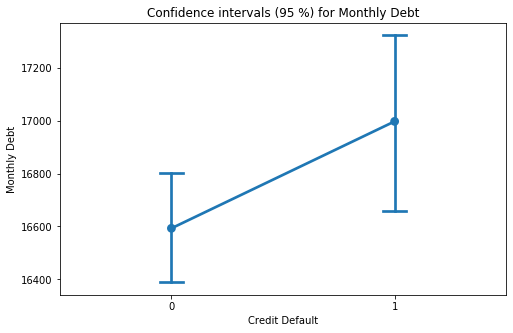

In [226]:
show_confidence_int(df, curr_name)

<h2><span style="color:red">Monthly Debt</span> END<br>________________________________

<h2 ><span style="color:red">Current Credit Balance</span> BEGIN

In [227]:
curr_name = 'Current Credit Balance'

In [228]:
quantile_p = int(df[curr_name].quantile(0.99))
df = mod_remove_tail(df, curr_name, quantile_p)
df_test = mod_remove_tail(df_test, curr_name, quantile_p)

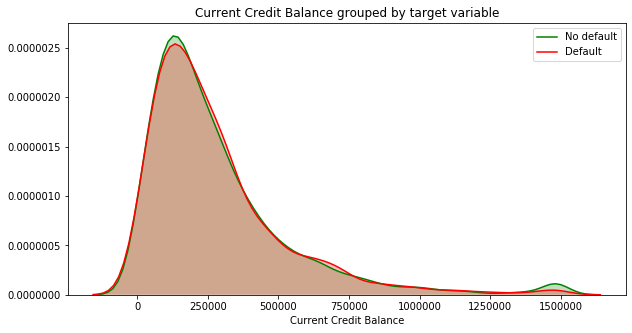

In [229]:
show_plot_matching(df, curr_name)

In [230]:
show_mannwhitneyu(df, curr_name)

MannwhitneyuResult(statistic=5688008.0, pvalue=0.484127151318837)

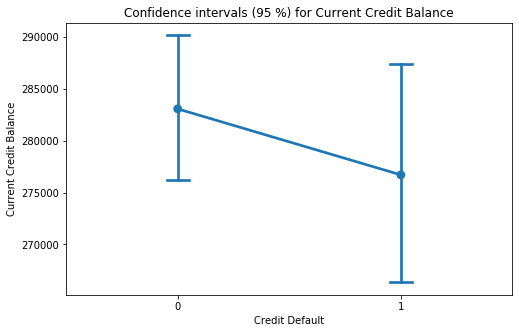

In [231]:
show_confidence_int(df, curr_name)

In [232]:
drop_columns.append(curr_name)

<h2><span style="color:red">Current Credit Balance</span> END<br>________________________________

<h2 ><span style="color:red">Maximum Open Credit</span> BEGIN

In [233]:
curr_name = 'Maximum Open Credit'

In [234]:
df[curr_name].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

In [235]:
quantile_p = int(df[curr_name].quantile(0.80))
df = mod_remove_tail(df, curr_name, quantile_p)
df_test = mod_remove_tail(df_test, curr_name, quantile_p)

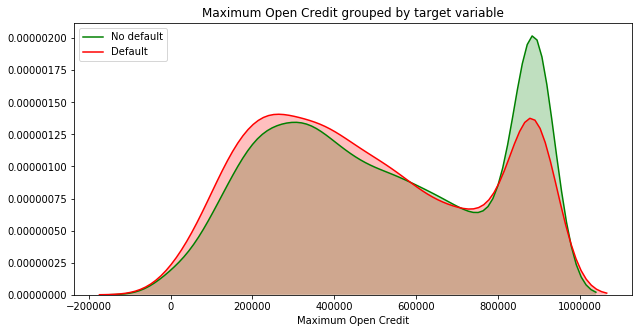

In [236]:
show_plot_matching(df, curr_name)

In [237]:
show_mannwhitneyu(df, curr_name)

MannwhitneyuResult(statistic=5242524.0, pvalue=4.5836369369943376e-08)

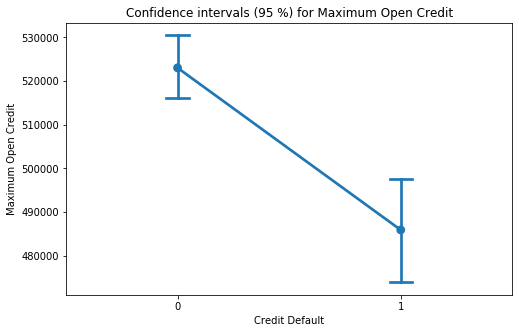

In [238]:
show_confidence_int(df, curr_name)

<h2><span style="color:red">Maximum Open Credit</span> END<br>________________________________

<h2 ><span style="color:red">Number of Open Accounts</span> BEGIN

In [239]:
curr_name = 'Number of Open Accounts'

In [240]:
quantile_p = int(df[curr_name].quantile(0.7))
df = mod_remove_tail(df, curr_name, quantile_p)
df_test = mod_remove_tail(df_test, curr_name, quantile_p)

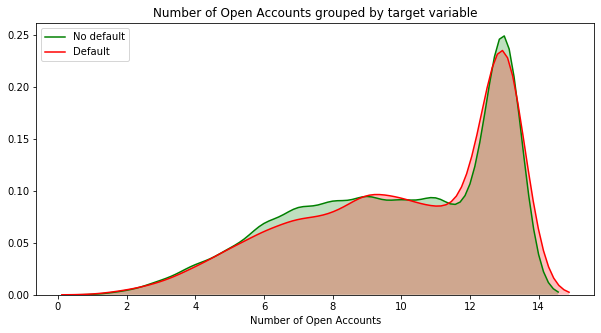

In [241]:
show_plot_matching(df, curr_name)

In [242]:
show_mannwhitneyu(df, curr_name)

MannwhitneyuResult(statistic=5468323.0, pvalue=0.0035057186838006443)

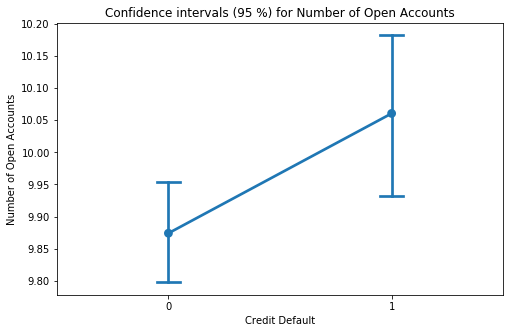

In [243]:
show_confidence_int(df, curr_name)

<h2><span style="color:red">Number of Open Accounts</span> END<br>________________________________

<h2 ><span style="color:red">Credit Score</span> BEGIN

In [244]:
curr_name = 'Credit Score'

In [245]:
median = df[curr_name].median()
df = mod_Credit_Score(df, median)
df_test = mod_Credit_Score(df_test, median)

In [246]:
quantile_p = int(df[curr_name].quantile(0.95))
df = mod_remove_tail(df, curr_name, quantile_p)
df_test = mod_remove_tail(df_test, curr_name, quantile_p)

quantile_p = int(df[curr_name].quantile(0.03))
df = mod_remove_tail(df, curr_name, quantile_p, left=True)
df_test = mod_remove_tail(df_test, curr_name, quantile_p, left=True)

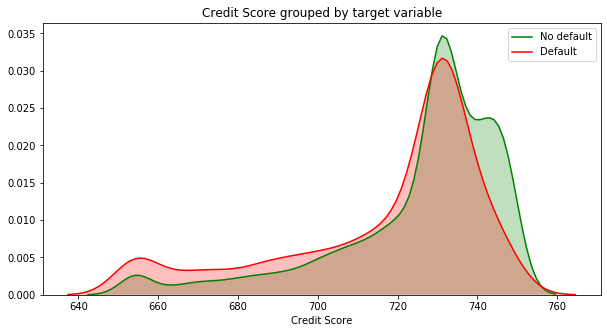

In [247]:
show_plot_matching(df, curr_name)

In [248]:
show_mannwhitneyu(df, curr_name)

MannwhitneyuResult(statistic=4435682.5, pvalue=5.754972474742408e-51)

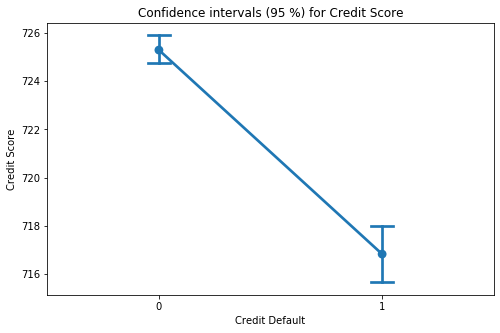

In [249]:
show_confidence_int(df, curr_name)

<h2><span style="color:red">Credit Score</span> END<br>________________________________

<h2 ><span style="color:red">Annual Income</span> BEGIN

In [250]:
curr_name = 'Annual Income'

In [251]:
median = df[curr_name].median()
p = int(df[curr_name].quantile(0.80))
df = mod_Annual_Income(df, median, p)
df_test = mod_Annual_Income(df_test, median, p)

In [252]:
p

1787071

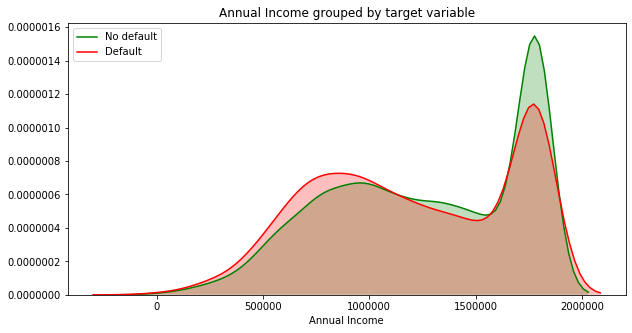

In [253]:
show_plot_matching(df, curr_name)

In [254]:
show_mannwhitneyu(df, curr_name)

MannwhitneyuResult(statistic=5261933.0, pvalue=1.376181599637444e-07)

<h2><span style="color:red">Annual Income</span> END<br>________________________________

<h2 ><span style="color:red">NEW NAMES</span> BEGIN

In [255]:
new_names = {new_Credit_Score_bin:{}, 
             new_Months_since_last_delinquent_dummy: {},
             new_Bankruptcies_bin:{},
             new_Bankruptcies_bin2: {}
            }

for new_col, params in new_names.items():
    df = new_col(df, **params)
    df_test = new_col(df_test, **params)

<h2><span style="color:red">NEW NAMES</span> END<br>________________________________

In [256]:
df_final = df.drop(columns=['Id']).copy()
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 21 columns):
Home Ownership                        7500 non-null int64
Annual Income                         7500 non-null float64
Years in current job                  7500 non-null int64
Tax Liens                             7500 non-null int8
Number of Open Accounts               7500 non-null float64
Years of Credit History               7500 non-null float64
Maximum Open Credit                   7500 non-null float64
Number of Credit Problems             7500 non-null int64
Months since last delinquent          7500 non-null float64
Bankruptcies                          7500 non-null int8
Purpose                               7500 non-null object
Term                                  7500 non-null int8
Current Loan Amount                   7500 non-null float64
Current Credit Balance                7500 non-null float64
Monthly Debt                          7500 non-null float64
Credit Sc

In [257]:
df_final_test = df_test.drop(columns=['Id']).copy()
df_final_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 20 columns):
Home Ownership                        2500 non-null int64
Annual Income                         2500 non-null float64
Years in current job                  2500 non-null int64
Tax Liens                             2500 non-null int8
Number of Open Accounts               2500 non-null float64
Years of Credit History               2500 non-null float64
Maximum Open Credit                   2500 non-null float64
Number of Credit Problems             2500 non-null int64
Months since last delinquent          2500 non-null float64
Bankruptcies                          2500 non-null int8
Purpose                               2500 non-null object
Term                                  2500 non-null int8
Current Loan Amount                   2500 non-null float64
Current Credit Balance                2500 non-null float64
Monthly Debt                          2500 non-null float64
Credit Sc

***Выделим бинарные переменные***

In [258]:
binary_columns = [c for c in df_final.columns if len(df_final[c].unique()) < 3]
binary_columns.remove(TARGET_NAME)
binary_columns

['Home Ownership',
 'Tax Liens',
 'Term',
 'Credit Score_bin',
 'Bankruptcies_bin',
 'Bankruptcies_bin2']

In [259]:
df[binary_columns] = df[binary_columns].astype('uint8')
df_test[binary_columns] = df_test[binary_columns].astype('uint8')
df[binary_columns].describe()

,Home Ownership,Tax Liens,Term,Credit Score_bin,Bankruptcies_bin,Bankruptcies_bin2
count,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,0.513467,0.006800,0.259200,0.193200,0.110133,0.005333
std,0.499852,0.082187,0.438225,0.394835,0.313077,0.072840
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


***Выделим дамми переменные***

In [260]:
nonbinary_columns = [c for c in df_final.columns if len(df_final[c].unique()) in range(3, 10)]
nonbinary_columns

['Number of Credit Problems',
 'Bankruptcies',
 'Purpose',
 'Months since last delinquent_dummy']

In [261]:
df_final[nonbinary_columns] = df_final[nonbinary_columns].astype('str')
df_final_test[nonbinary_columns] = df_final_test[nonbinary_columns].astype('str')
df_final[nonbinary_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 4 columns):
Number of Credit Problems             7500 non-null object
Bankruptcies                          7500 non-null object
Purpose                               7500 non-null object
Months since last delinquent_dummy    7500 non-null object
dtypes: object(4)
memory usage: 234.5+ KB


***Рассмотрим числовые переменные***

In [262]:
numerical_columns = list(set(df_final.columns) - set(binary_columns) - set(nonbinary_columns) - set([TARGET_NAME]))
df[numerical_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 10 columns):
Annual Income                   7500 non-null float64
Current Credit Balance          7500 non-null float64
Credit Score                    7500 non-null float64
Months since last delinquent    7500 non-null float64
Number of Open Accounts         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Years of Credit History         7500 non-null float64
Monthly Debt                    7500 non-null float64
Years in current job            7500 non-null int64
Current Loan Amount             7500 non-null float64
dtypes: float64(9), int64(1)
memory usage: 586.0 KB


In [263]:
nonbinary_dummy_data = pd.get_dummies(df_final[nonbinary_columns])

In [264]:
binary_data = df_final[binary_columns]

In [265]:
numerical_data = df_final[numerical_columns]

In [266]:
df_final = pd.concat([numerical_data, binary_data, nonbinary_dummy_data, df_final[TARGET_NAME]], axis=1)
df_final.head()

,Annual Income,Current Credit Balance,Credit Score,Months since last delinquent,Number of Open Accounts,Maximum Open Credit,Years of Credit History,Monthly Debt,Years in current job,Current Loan Amount,...,Purpose_1,Purpose_2,Purpose_3,Months since last delinquent_dummy_0,Months since last delinquent_dummy_1,Months since last delinquent_dummy_2,Months since last delinquent_dummy_3,Months since last delinquent_dummy_4,Months since last delinquent_dummy_5,Credit Default
0,482087.0,47386.0,748.0,32.0,11.0,685960.0,20.0,7914.0,10,0.0,...,0,0,0,0,0,0,0,1,0,0
1,1025487.0,394972.0,737.0,130.0,13.0,891409.0,15.3,18373.0,10,264968.0,...,0,0,0,0,0,0,0,0,1,1
2,751412.0,308389.0,742.0,130.0,11.0,891409.0,20.0,13651.0,8,0.0,...,0,0,0,0,0,0,0,0,1,0
3,805068.0,95855.0,694.0,32.0,8.0,147400.0,20.0,11338.0,6,121396.0,...,0,0,0,0,0,0,0,1,0,0
4,776264.0,93309.0,719.0,32.0,13.0,385836.0,13.6,7180.0,8,125840.0,...,0,0,0,0,0,0,0,1,0,0


In [267]:
nonbinary_dummy_data_test = pd.get_dummies(df_final_test[nonbinary_columns])
binary_data_test = df_final_test[binary_columns]
numerical_data_test = df_final_test[numerical_columns]
df_final_test = pd.concat([numerical_data_test, binary_data_test, nonbinary_dummy_data_test], axis=1)
df_final.head()

,Annual Income,Current Credit Balance,Credit Score,Months since last delinquent,Number of Open Accounts,Maximum Open Credit,Years of Credit History,Monthly Debt,Years in current job,Current Loan Amount,...,Purpose_1,Purpose_2,Purpose_3,Months since last delinquent_dummy_0,Months since last delinquent_dummy_1,Months since last delinquent_dummy_2,Months since last delinquent_dummy_3,Months since last delinquent_dummy_4,Months since last delinquent_dummy_5,Credit Default
0,482087.0,47386.0,748.0,32.0,11.0,685960.0,20.0,7914.0,10,0.0,...,0,0,0,0,0,0,0,1,0,0
1,1025487.0,394972.0,737.0,130.0,13.0,891409.0,15.3,18373.0,10,264968.0,...,0,0,0,0,0,0,0,0,1,1
2,751412.0,308389.0,742.0,130.0,11.0,891409.0,20.0,13651.0,8,0.0,...,0,0,0,0,0,0,0,0,1,0
3,805068.0,95855.0,694.0,32.0,8.0,147400.0,20.0,11338.0,6,121396.0,...,0,0,0,0,0,0,0,1,0,0
4,776264.0,93309.0,719.0,32.0,13.0,385836.0,13.6,7180.0,8,125840.0,...,0,0,0,0,0,0,0,1,0,0


In [268]:
drop_columns

['Id',
 'Years in current job',
 'Bankruptcies',
 'Months since last delinquent',
 'Current Credit Balance']

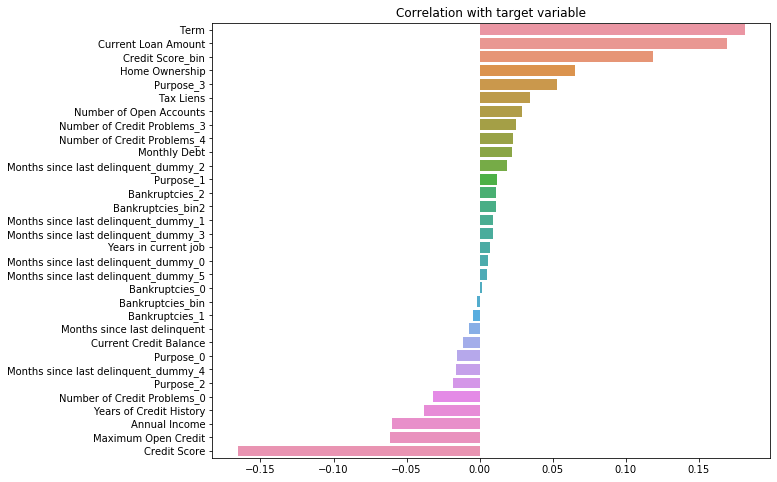

In [269]:
BASE_FEATURE_NAMES = df_final.columns.tolist()
corr_with_target = df_final[BASE_FEATURE_NAMES].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values[:], y=corr_with_target.index[:])

plt.title('Correlation with target variable')
plt.show()

In [270]:
scaled = True
df_final_scaled = mod_scaler(df_final)
df_final_test_scaled = mod_scaler(df_final_test)

In [271]:
for c in corr_with_target.abs().sort_values(ascending = False).index:
    print(f'\'{c}\',')

'Term',
'Current Loan Amount',
'Credit Score',
'Credit Score_bin',
'Home Ownership',
'Maximum Open Credit',
'Annual Income',
'Purpose_3',
'Years of Credit History',
'Tax Liens',
'Number of Credit Problems_0',
'Number of Open Accounts',
'Number of Credit Problems_3',
'Number of Credit Problems_4',
'Monthly Debt',
'Months since last delinquent_dummy_2',
'Purpose_2',
'Months since last delinquent_dummy_4',
'Purpose_0',
'Purpose_1',
'Current Credit Balance',
'Bankruptcies_bin2',
'Bankruptcies_2',
'Months since last delinquent_dummy_1',
'Months since last delinquent_dummy_3',
'Months since last delinquent',
'Years in current job',
'Months since last delinquent_dummy_0',
'Months since last delinquent_dummy_5',
'Bankruptcies_1',
'Bankruptcies_bin',
'Bankruptcies_0',


In [272]:
FEATURE_NAMES_SELECTED = [
'Term',
'Current Loan Amount',
'Credit Score',
'Credit Score_bin',
'Home Ownership',
'Maximum Open Credit',
'Annual Income',
'Purpose_3',
'Years of Credit History',
'Tax Liens',
'Number of Credit Problems_0',
'Number of Open Accounts',
'Number of Credit Problems_3',
'Number of Credit Problems_4',
'Monthly Debt',
'Months since last delinquent_dummy_2',
'Purpose_2',
'Months since last delinquent_dummy_4',
'Purpose_0',
'Purpose_1',
# 'Current Credit Balance',
'Bankruptcies_2',
'Bankruptcies_bin2',
'Months since last delinquent_dummy_1',
'Months since last delinquent_dummy_3',
'Months since last delinquent',
'Years in current job',
# 'Months since last delinquent_dummy_0',
# 'Months since last delinquent_dummy_5',
# 'Bankruptcies_1',
# 'Bankruptcies_bin',
# 'Bankruptcies_0',
]


In [273]:
drop_columns

['Id',
 'Years in current job',
 'Bankruptcies',
 'Months since last delinquent',
 'Current Credit Balance']

In [274]:
scaled = True
X = df_final_scaled[FEATURE_NAMES_SELECTED] if scaled else df_final[FEATURE_NAMES_SELECTED]
y = df_final_scaled[TARGET_NAME] if scaled else df_final[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)
X.head()

,Term,Current Loan Amount,Credit Score,Credit Score_bin,Home Ownership,Maximum Open Credit,Annual Income,Purpose_3,Years of Credit History,Tax Liens,...,Purpose_2,Months since last delinquent_dummy_4,Purpose_0,Purpose_1,Bankruptcies_2,Bankruptcies_bin2,Months since last delinquent_dummy_1,Months since last delinquent_dummy_3,Months since last delinquent,Years in current job
0,0,-1.380382,1.091055,0,1,0.635664,-1.687713,0,0.979307,0,...,0,1,1,0,0,0,0,0,-0.937873,1.075647
1,1,-0.041483,0.612741,0,1,1.388906,-0.498114,0,-0.247066,0,...,0,0,1,0,0,0,0,0,1.013839,1.075647
2,0,-1.380382,0.830156,0,0,1.388906,-1.098113,0,0.979307,0,...,0,0,1,0,0,0,0,0,1.013839,0.526268
3,0,-0.766961,-1.257033,1,1,-1.338870,-0.980650,0,0.979307,0,...,0,1,1,0,0,0,0,0,-0.937873,-0.023111
4,0,-0.744505,-0.169955,0,1,-0.464687,-1.043707,0,-0.690648,0,...,0,1,1,0,0,0,0,0,-0.937873,0.526268


In [275]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, 1)
    
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]
df_balanced[TARGET_NAME].value_counts()

0    4047
1    3156
Name: Credit Default, dtype: int64

In [287]:
params = {
    "learning_rate":0.01,
    "max_depth": 2,
    "n_estimators": 1650
}

MODEL = lgbm.LGBMClassifier

model = MODEL(**params, silent=True, random_state=21)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
print(f1_score(y_test, y_test_pred))

TRAIN
              precision    recall  f1-score   support

           0       0.69      0.73      0.71      4047
           1       0.63      0.59      0.61      3156

    accuracy                           0.67      7203
   macro avg       0.66      0.66      0.66      7203
weighted avg       0.66      0.67      0.67      7203

TEST
              precision    recall  f1-score   support

           0       0.81      0.71      0.76      1340
           1       0.44      0.58      0.50       535

    accuracy                           0.67      1875
   macro avg       0.63      0.64      0.63      1875
weighted avg       0.70      0.67      0.68      1875

CONFUSION MATRIX

col_0           0.0  1.0
Credit Default          
0               952  388
1               226  309
0.5016233766233766


In [285]:
gred_params = {
    "learning_rate": [0.01],
    "max_depth": [2,],
    "n_estimators": range(250, 2651, 100)
}

MODEL = lgbm.LGBMClassifier

def gred_model(modelClassifier, gred_params, X_train, y_train, X_test, y_test):
    max_f1 = result = 0
    max_params = params = {}
    iter_len = reduce(lambda x, y: x*y, [len(p) for p in gred_params.values()])
    with tqdm(product(*gred_params.values()), 
              total=iter_len,  
              bar_format='{l_bar} {bar} |{n_fmt}/{total_fmt}|{remaining}| {postfix}') as gred_dicts:
        for i in gred_dicts:
            params = dict(zip(gred_params.keys(), i))
            model = modelClassifier(**params, random_state=21, eval_metric="F1", silent=True)
            model.fit(X_train, y_train)
            y_test_pred = model.predict(X_test)
            result = f1_score(y_test, y_test_pred)
            if result > max_f1:
                max_f1 = result
                max_params = params
            gred_dicts.set_postfix_str(s=f'| Max_f1={round(max_f1, 5)} | last_f1={round(result, 5)} | best={max_params} | \
                                        current={params}', refresh=True)
    return max_f1, max_params
def gred_names(modelClassifier, gred_params, X_train, y_train, X_test, y_test, output='output.csv'):
    between = 5
    test_names = FEATURE_NAMES_SELECTED[:between]
    f1_prev = 0
    for name in FEATURE_NAMES_SELECTED[between:]:
        test_names.append(name)
        X = df_final_scaled[test_names]
        y = df_final_scaled[TARGET_NAME]
        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=211)

        df_for_balancing = pd.concat([X_train, y_train], axis=1)
        df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, 1)

        X_train = df_balanced.drop(columns=TARGET_NAME)
        y_train = df_balanced[TARGET_NAME]
        
        f1, params = gred_model(modelClassifier, gred_params, X_train, y_train, X_test, y_test)
        with open(output, 'a') as file:
            file.write(f'{name},{f1},{f1 > f1_prev}\n')
        f1_prev = f1

# gred_names(MODEL, gred_params, X_train, y_train, X_test, y_test, output='output.csv')
gred_model(MODEL, gred_params, X_train, y_train, X_test, y_test)

100%| ██████████ |25/25|00:00| , | Max_f1=0.51406 | last_f1=0.49473 | best={'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1650} |                                         current={'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 2650}


(0.5140562248995983,
 {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1650})

In [278]:
df_for_balancing = pd.concat([X, y], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, 1)
    
X_full_train = df_balanced.drop(columns=TARGET_NAME)
y_full_train = df_balanced[TARGET_NAME]
df_balanced[TARGET_NAME].value_counts()

0    5387
1    4226
Name: Credit Default, dtype: int64

In [279]:
model.fit(X_full_train, y_full_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=2,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=2450, n_jobs=-1, num_leaves=31, objective=None,
               random_state=21, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [280]:
y_pred = model.predict(df_final_test_scaled[FEATURE_NAMES_SELECTED])

In [281]:
sum(y_pred), sum(y_test_pred), sum(y_train_pred)

(865, 696, 3033)

In [282]:
len(y_pred)

2500

In [283]:
df_test[TARGET_NAME] = y_pred

In [284]:
df_test[['Id', TARGET_NAME]].astype('int').to_csv(PRED_OUTPUT_FILE, index=None)